In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [67]:
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, precision_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [68]:
df=pd.read_csv("AIML Dataset.csv")

In [69]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [70]:
df.drop(columns="step", inplace=True)

In [71]:
df_model= df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

In [72]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [73]:
categorical= ["type"]
numeric= ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

In [74]:
le = LabelEncoder()
df_model["type"] = le.fit_transform(df_model["type"]) 

In [75]:
y= df_model["isFraud"]
X= df_model.drop("isFraud", axis= 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [77]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [78]:
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight: {scale:.2f}")

scale_pos_weight: 773.75


In [79]:
model = XGBClassifier(
    scale_pos_weight=scale,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [80]:
y_proba = model.predict_proba(X_test)[:, 1]

In [81]:
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

In [82]:
print("\nClassification Report (Threshold = 0.5):")
print(classification_report(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))


Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.47      0.99      0.64      1643

    accuracy                           1.00   1272524
   macro avg       0.74      0.99      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524

Precision: 0.4733918128654971


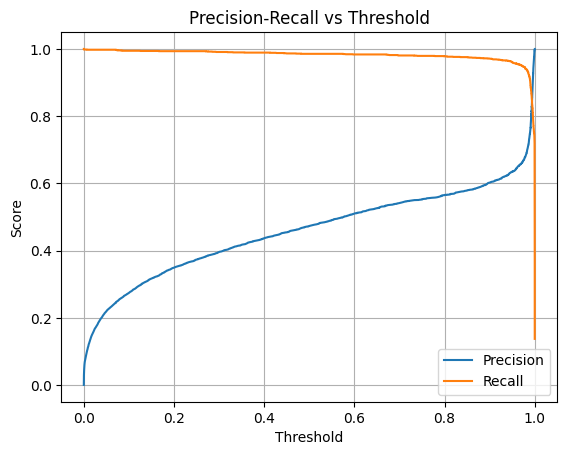

In [83]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [84]:
print(f"y_test shape: {y_test.shape}")
print(f"y_proba shape: {y_proba.shape}")

y_test shape: (1272524,)
y_proba shape: (1272524,)


In [85]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold (F1 Score): {best_threshold:.3f}")

Best Threshold (F1 Score): 0.995


In [86]:
y_pred_custom = (y_proba >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.89      0.82      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.91      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

Precision: 0.8921244209133025


In [87]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (5090096, 6)
y_train shape: (5090096,)


In [88]:
print("df shape:", df.shape)

df shape: (6362620, 10)


In [89]:
print("Features used in training (X_train columns):")
print(X_train.columns)

print("\nSample rows:")
print(X_train.head())


Features used in training (X_train columns):
Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

Sample rows:
         type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
292779      3    9914.74       44248.00        34333.26            0.00   
499763      3    6854.53           0.00            0.00            0.00   
2970411     1  361211.80           0.00            0.00       489745.16   
3137549     3    7083.51           0.00            0.00            0.00   
1500682     0  218019.51    13045685.58     13263705.09      2438123.98   

         newbalanceDest  
292779             0.00  
499763             0.00  
2970411       850956.95  
3137549            0.00  
1500682      2220104.47  


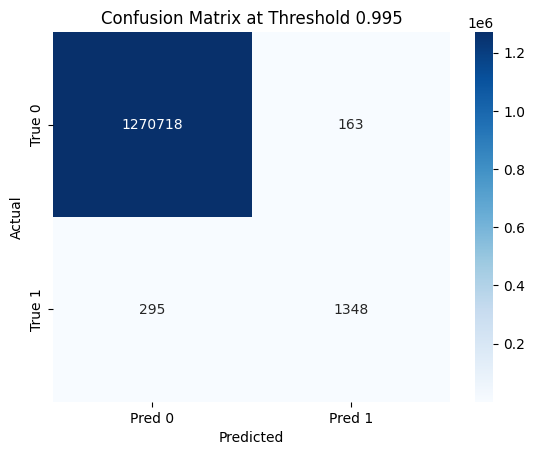

In [90]:
cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title(f"Confusion Matrix at Threshold {best_threshold:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


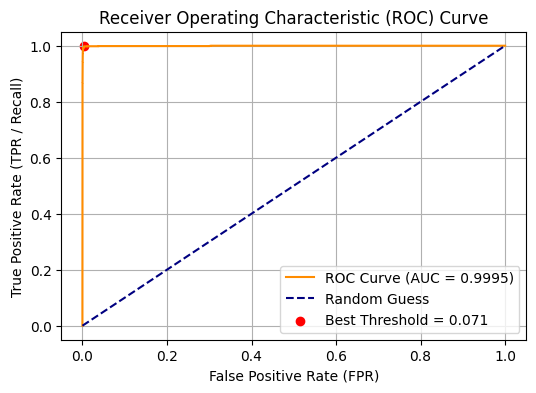

In [91]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
best_threshold = thresholds[np.argmax(tpr - fpr)]

# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Guess')
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], color='red',
            label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


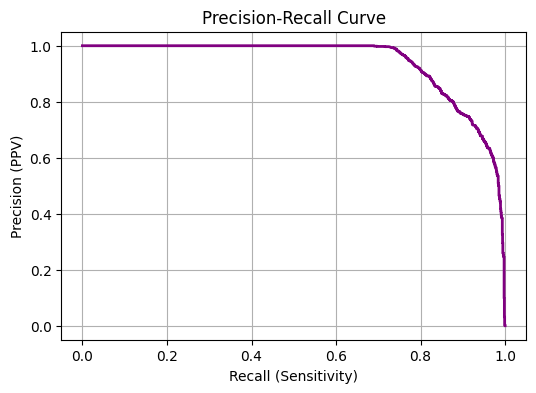

In [92]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


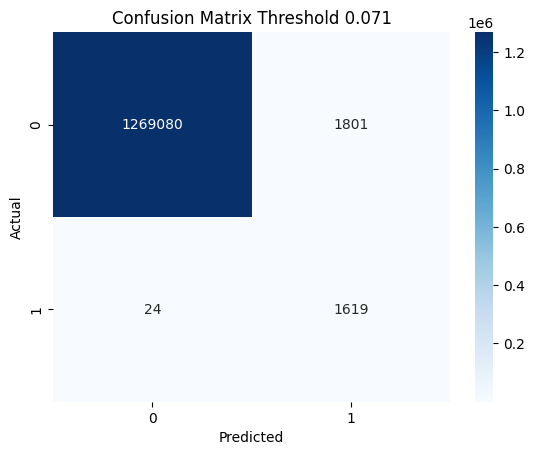

In [93]:
y_pred_new = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix Threshold {best_threshold:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_new))
print("Precision:", precision_score(y_test, y_pred_new))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.25      1.00      0.40      1643

    accuracy                           1.00   1272524
   macro avg       0.62      1.00      0.70   1272524
weighted avg       1.00      1.00      1.00   1272524

Precision: 0.24672587686286315


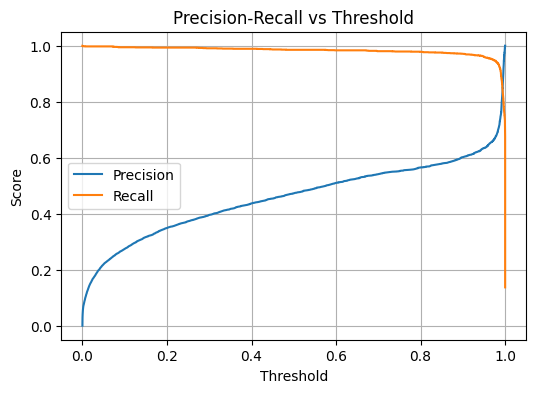

In [95]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


In [96]:
from sklearn.metrics import f1_score

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print("Best F1:", f1_scores[best_index], "at Threshold:", best_threshold)


Best F1: 0.8547875713379836 at Threshold: 0.9953544
